In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Basics
import tensorflow as tf
import pandas as pd
import xarray as xr

# Helpful
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt

# My Methods
from src.utils.CRPS import *  # CRPS metrics
from src.utils.data_split import *  # Splitting data into X and y
from src.utils.drn_make_X_array import *  # Import make train array functions (make_X_array)
from src.models.EMOS import *  # EMOS implementation
from src.models.DRN.DRN_model import *  # DRN implementation
from src.models.DRN.DRN_load_score import *  # Load DRN_scores
from src.models.DRN.DRN_load_model import *  # Load Models
from src.models.DRN.DRN_train import *
from src.models.EMOS_local.EMOS_local_load_score import *  # Load EMOS_local_scores
from src.models.EMOS_global.EMOS_global_load_score import *  # Load EMOS_global_scores
from src.models.EMOS_global.EMOS_global_load_model import *  # Load EMOS_global_models#
import data.raw.load_data_raw as ldr  # Load raw data
import data.processed.load_data_processed as ldp  # Load processed data normed
import data.processed.load_data_processed_denormed as ldpd  # Load processed data denormed
from src.models.CRPS_baseline.CRPS_load import *  # Load CRPS scores

2023-06-14 15:13:32.413238: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/anaconda3/lib/
2023-06-14 15:13:32.413269: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


<IPython.core.display.Javascript object>

### 1. Loading Data and Splitting

In [3]:
# Load all training data and validation data of each variable
train_var_denormed, val_var_denormed = ldpd.load_data_all_train_val_proc_denorm()
# Load all test data of each variable:
test_var_denormed = ldpd.load_data_all_test_proc_denorm()

<IPython.core.display.Javascript object>

In [4]:
# Split all 3 datasets into X and y for each lead_time
dat_X_train_lead_all_denorm, dat_y_train_lead_all_denorm = split_var_lead(
    train_var_denormed
)
dat_X_val_lead_all_denorm, dat_y_val_lead_all_denorm = split_var_lead(val_var_denormed)

dat_X_test_lead_all_denorm, dat_y_test_lead_all_denorm = split_var_lead(
    test_var_denormed
)

<IPython.core.display.Javascript object>

### 2. Heatmap values

#### 2.1 Heatmap mean values X

In [29]:
def visualize_X_train_val_test_hm(mean_std=0, var_num=5, lead_time=0):
    fig, ax = plt.subplots(1, 3, figsize=(25, 25))  # Create three subplots

    train_data_mean = (
        dat_X_train_lead_all_denorm[var_num][lead_time]
        .isel(mean_std=mean_std)
        .mean(dim="forecast_date")
    )
    val_data_mean = (
        dat_X_val_lead_all_denorm[var_num][lead_time]
        .isel(mean_std=mean_std)
        .mean(dim="forecast_date")
    )
    test_data_mean = (
        dat_X_test_lead_all_denorm[var_num][lead_time]
        .isel(mean_std=mean_std)
        .mean(dim="forecast_date")
    )

    # Calculate common scale for all three heatmaps
    vmin = min(train_data_mean.min(), val_data_mean.min(), test_data_mean.min())
    vmax = max(train_data_mean.max(), val_data_mean.max(), test_data_mean.max())

    # Training data heatmap
    im = ax[0].imshow(
        train_data_mean.values,
        cmap="viridis",
        vmin=vmin,
        vmax=vmax,  # Use common scale
    )
    ax[0].set_title(f"Average Colormap WS X training, lead_time: {lead_time}")
    fig.colorbar(im, ax=ax[0], shrink=0.3).set_label("WS in Kelvin")

    # Validation data heatmap
    im = ax[1].imshow(
        val_data_mean.values, cmap="viridis", vmin=vmin, vmax=vmax,  # Use common scale
    )
    ax[1].set_title(f"Average Colormap WS X validation, lead_time: {lead_time}")
    fig.colorbar(im, ax=ax[1], shrink=0.3).set_label("WS in Kelvin")

    # Test data heatmap
    im = ax[2].imshow(
        test_data_mean.values, cmap="viridis", vmin=vmin, vmax=vmax,  # Use common scale
    )
    ax[2].set_title(f"Average Colormap WS X testing, lead_time: {lead_time}")
    fig.colorbar(im, ax=ax[2], shrink=0.3).set_label("WS in Kelvin")

    plt.show()

<IPython.core.display.Javascript object>

#### Figure 1

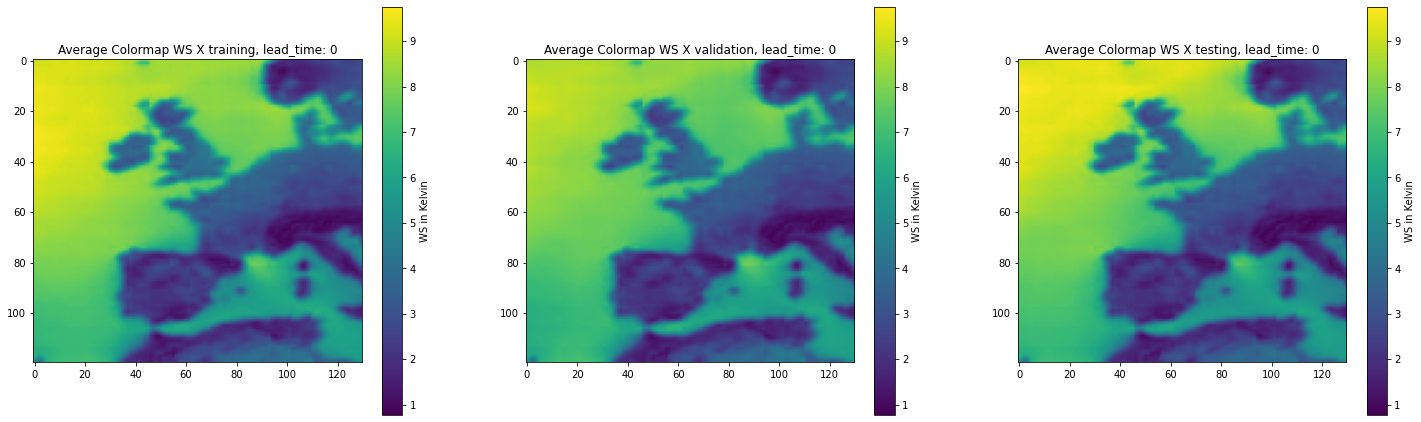

<IPython.core.display.Javascript object>

In [30]:
visualize_X_train_val_test_hm(lead_time=0)

#### 2.2 Difference X_values heatmap

In [25]:
def visualize_X_diff_hm(mean_std=0, var_num=5, lead_time=0):
    fig, ax = plt.subplots(1, 2, figsize=(17, 17))  # Create two subplots

    train_data_mean = (
        dat_X_train_lead_all_denorm[var_num][lead_time]
        .isel(mean_std=mean_std)
        .mean(dim="forecast_date")
    )
    val_data_mean = (
        dat_X_val_lead_all_denorm[var_num][lead_time]
        .isel(mean_std=mean_std)
        .mean(dim="forecast_date")
    )
    test_data_mean = (
        dat_X_test_lead_all_denorm[var_num][lead_time]
        .isel(mean_std=mean_std)
        .mean(dim="forecast_date")
    )

    # Calculate differences
    diff_test_train = test_data_mean - train_data_mean
    diff_test_val = test_data_mean - val_data_mean

    # Calculate common scale for both heatmaps
    vmin = min(diff_test_train.min(), diff_test_val.min())
    vmax = max(diff_test_train.max(), diff_test_val.max())

    # Test-Train heatmap
    im = ax[0].imshow(
        diff_test_train.values, cmap="RdBu", vmin=vmin, vmax=vmax,  # Use common scale
    )
    ax[0].set_title(f"Difference between Test and Train X, lead_time: {lead_time}")
    fig.colorbar(im, ax=ax[0], shrink=0.3).set_label("Difference in WS in Kelvin")

    # Test-Validation heatmap
    im = ax[1].imshow(
        diff_test_val.values, cmap="RdBu", vmin=vmin, vmax=vmax,  # Use common scale
    )
    ax[1].set_title(f"Difference between Test and Validation X, lead_time: {lead_time}")
    fig.colorbar(im, ax=ax[1], shrink=0.3).set_label("Difference in WS in Kelvin")

    plt.show()

<IPython.core.display.Javascript object>

#### Figure 2

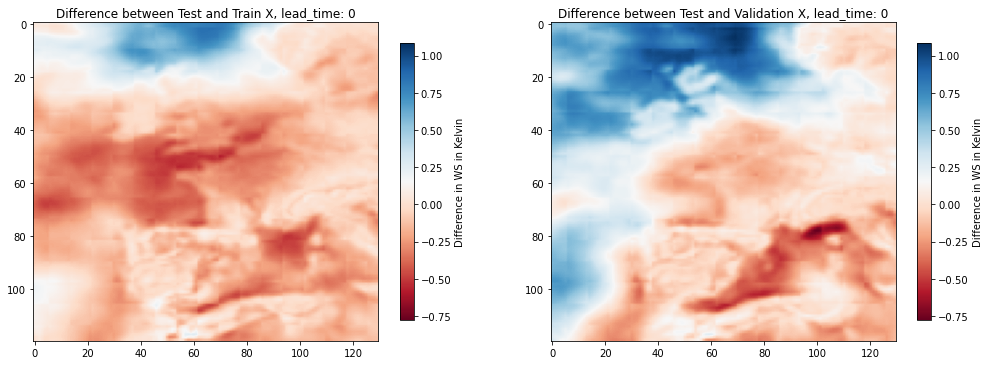

<IPython.core.display.Javascript object>

In [26]:
visualize_X_diff_hm(lead_time=0)

#### 2.2 Heatmap y means

In [9]:
def visualize_y_train_val_test_hm(mean_std=0, var_num=5, lead_time=0):
    fig, ax = plt.subplots(1, 3, figsize=(25, 25))  # Create three subplots

    train_data_mean = dat_y_train_lead_all_denorm[var_num][lead_time].mean(
        dim="forecast_date"
    )
    val_data_mean = dat_y_val_lead_all_denorm[var_num][lead_time].mean(
        dim="forecast_date"
    )
    test_data_mean = dat_y_test_lead_all_denorm[var_num][lead_time].mean(
        dim="forecast_date"
    )

    # Calculate common scale for all three heatmaps
    vmin = min(train_data_mean.min(), val_data_mean.min(), test_data_mean.min())
    vmax = max(train_data_mean.max(), val_data_mean.max(), test_data_mean.max())

    # Training data heatmap
    im = ax[0].imshow(
        train_data_mean.values,
        cmap="viridis",
        vmin=vmin,
        vmax=vmax,  # Use common scale
    )
    ax[0].set_title(f"Average Colormap WS y training, lead_time: {lead_time}")
    fig.colorbar(im, ax=ax[0], shrink=0.3).set_label("WS in Kelvin")

    # Validation data heatmap
    im = ax[1].imshow(
        val_data_mean.values, cmap="viridis", vmin=vmin, vmax=vmax,  # Use common scale
    )
    ax[1].set_title(f"Average Colormap WS y validation, lead_time: {lead_time}")
    fig.colorbar(im, ax=ax[1], shrink=0.3).set_label("WS in Kelvin")

    # Test data heatmap
    im = ax[2].imshow(
        test_data_mean.values, cmap="viridis", vmin=vmin, vmax=vmax,  # Use common scale
    )
    ax[2].set_title(f"Average Colormap WS y testing, lead_time: {lead_time}")
    fig.colorbar(im, ax=ax[2], shrink=0.3).set_label("WS in Kelvin")

    plt.show()

<IPython.core.display.Javascript object>

#### Figure 3

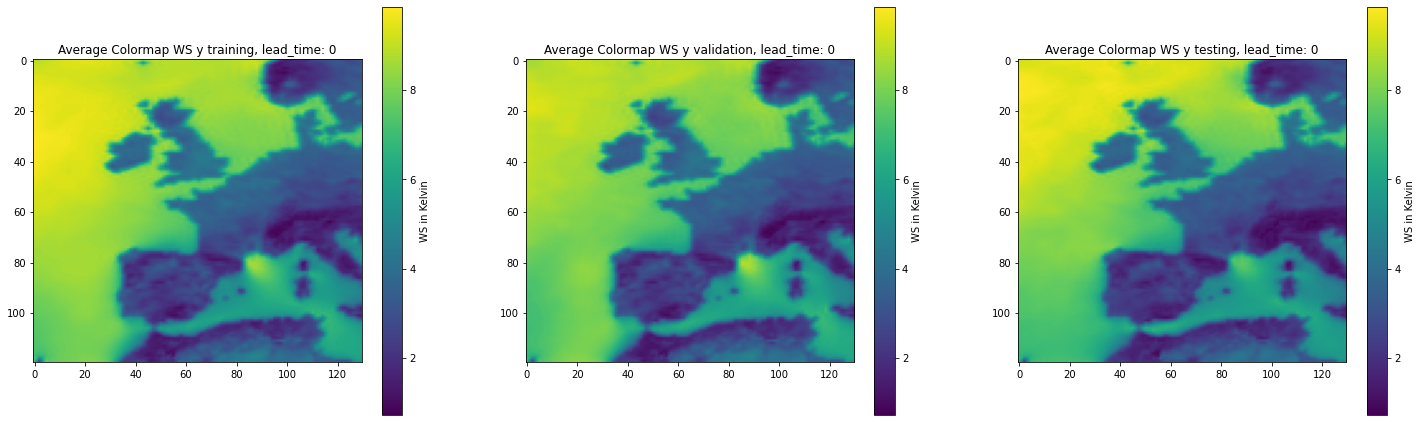

<IPython.core.display.Javascript object>

In [10]:
visualize_y_train_val_test_hm(lead_time=0)

#### 2.4 Heatmaps differences y values

In [27]:
def visualize_y_diff_hm(mean_std=0, var_num=5, lead_time=0):
    fig, ax = plt.subplots(1, 2, figsize=(17, 17))  # Create two subplots

    train_data_mean = dat_y_train_lead_all_denorm[var_num][lead_time].mean(
        dim="forecast_date"
    )
    val_data_mean = dat_y_val_lead_all_denorm[var_num][lead_time].mean(
        dim="forecast_date"
    )
    test_data_mean = dat_y_test_lead_all_denorm[var_num][lead_time].mean(
        dim="forecast_date"
    )

    # Calculate differences
    diff_test_train = test_data_mean - train_data_mean
    diff_test_val = test_data_mean - val_data_mean

    # Calculate common scale for both heatmaps
    vmin = min(diff_test_train.min(), diff_test_val.min())
    vmax = max(diff_test_train.max(), diff_test_val.max())

    # Test-Train heatmap
    im = ax[0].imshow(
        diff_test_train.values, cmap="RdBu", vmin=vmin, vmax=vmax,  # Use common scale
    )
    ax[0].set_title(f"Difference between Test and Train y, lead_time: {lead_time}")
    fig.colorbar(im, ax=ax[0], shrink=0.3).set_label("Difference in WS in Kelvin")

    # Test-Validation heatmap
    im = ax[1].imshow(
        diff_test_val.values, cmap="RdBu", vmin=vmin, vmax=vmax,  # Use common scale
    )
    ax[1].set_title(f"Difference between Test and Validation y, lead_time: {lead_time}")
    fig.colorbar(im, ax=ax[1], shrink=0.3).set_label("Difference in WS in Kelvin")

    plt.show()

<IPython.core.display.Javascript object>

#### Figure 4

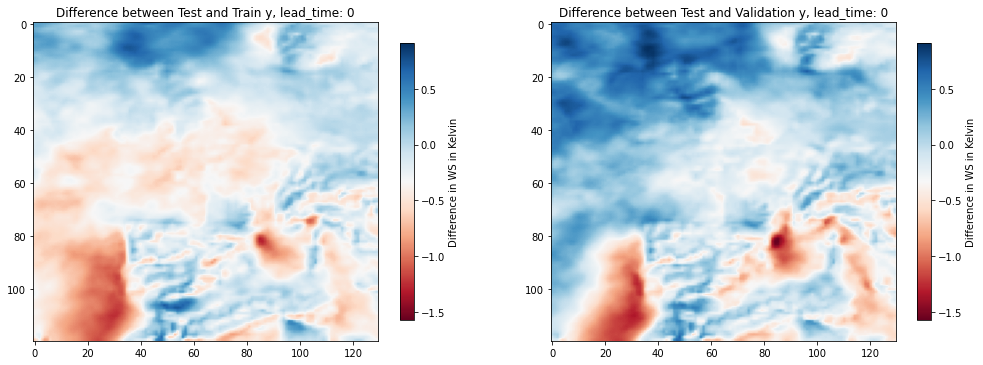

<IPython.core.display.Javascript object>

In [28]:
visualize_y_diff_hm(lead_time=0)

### 3. Histograms

#### 3.1 Histogramm X mean over grid for all forecasting days

In [13]:
def visualize_X_train_val_test_hist(mean_std=0, var_num=5, lead_time=0):
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))

    train_data_mean_per_day = (
        dat_X_train_lead_all_denorm[var_num][lead_time]
        .isel(mean_std=mean_std)
        .mean(dim=["lat", "lon"])
    )
    val_data_mean_per_day = (
        dat_X_val_lead_all_denorm[var_num][lead_time]
        .isel(mean_std=mean_std)
        .mean(dim=["lat", "lon"])
    )
    test_data_mean_per_day = (
        dat_X_test_lead_all_denorm[var_num][lead_time]
        .isel(mean_std=mean_std)
        .mean(dim=["lat", "lon"])
    )

    # Calculate common scale for all histograms
    data_min = min(
        train_data_mean_per_day.min(),
        val_data_mean_per_day.min(),
        test_data_mean_per_day.min(),
    )
    data_max = max(
        train_data_mean_per_day.max(),
        val_data_mean_per_day.max(),
        test_data_mean_per_day.max(),
    )
    bins = np.linspace(data_min, data_max, 20)  # adjust number of bins if necessary

    hist0, _ = np.histogram(train_data_mean_per_day.values, bins=bins, density=True)
    hist1, _ = np.histogram(val_data_mean_per_day.values, bins=bins, density=True)
    hist2, _ = np.histogram(test_data_mean_per_day.values, bins=bins, density=True)

    max_y = max(np.max(hist0), np.max(hist1), np.max(hist2))

    ax[0].hist(
        train_data_mean_per_day.values,
        bins=bins,
        color="green",
        alpha=0.7,
        density=True,
    )
    ax[0].set_title(f"Histogram of daily X means - training, lead_time: {lead_time}")
    ax[0].set_xlabel("Wind speed in m/s")
    ax[0].set_ylim([0, max_y])

    ax[1].hist(
        val_data_mean_per_day.values, bins=bins, color="blue", alpha=0.7, density=True
    )
    ax[1].set_title(f"Histogram of daily X means - validation, lead_time: {lead_time}")
    ax[1].set_xlabel("Wind speed in m/s")
    ax[1].set_ylim([0, max_y])

    ax[2].hist(
        test_data_mean_per_day.values, bins=bins, color="red", alpha=0.7, density=True
    )
    ax[2].set_title(f"Histogram of daily X means - testing, lead_time: {lead_time}")
    ax[2].set_xlabel("Wind speed in m/s")
    ax[2].set_ylim([0, max_y])

    plt.show()

<IPython.core.display.Javascript object>

#### Figure 5

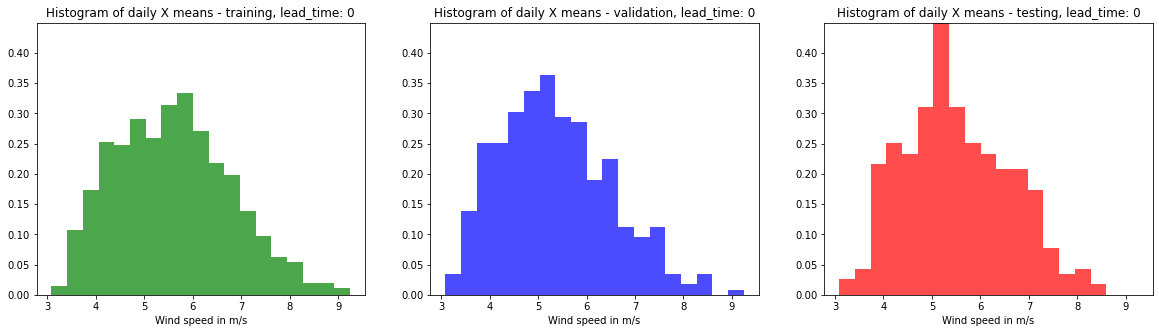

<IPython.core.display.Javascript object>

In [14]:
visualize_X_train_val_test_hist(lead_time=0)

#### 3.2 Histogram X differences mean over grid

In [15]:
def visualize_X_diff_hist(mean_std=0, var_num=5, lead_time=0):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    train_data_mean_per_day = (
        dat_X_train_lead_all_denorm[var_num][lead_time]
        .isel(mean_std=mean_std)
        .mean(dim=["lat", "lon"])
    )
    val_data_mean_per_day = (
        dat_X_val_lead_all_denorm[var_num][lead_time]
        .isel(mean_std=mean_std)
        .mean(dim=["lat", "lon"])
    )
    test_data_mean_per_day = (
        dat_X_test_lead_all_denorm[var_num][lead_time]
        .isel(mean_std=mean_std)
        .mean(dim=["lat", "lon"])
    )

    # Calculate common scale for all histograms
    data_min = min(
        train_data_mean_per_day.min(),
        val_data_mean_per_day.min(),
        test_data_mean_per_day.min(),
    )
    data_max = max(
        train_data_mean_per_day.max(),
        val_data_mean_per_day.max(),
        test_data_mean_per_day.max(),
    )
    bins = np.linspace(data_min, data_max, 20)  # adjust number of bins if necessary

    # Get histogram data
    train_hist, _ = np.histogram(
        train_data_mean_per_day.values, bins=bins, density=True
    )
    val_hist, _ = np.histogram(val_data_mean_per_day.values, bins=bins, density=True)
    test_hist, _ = np.histogram(test_data_mean_per_day.values, bins=bins, density=True)

    # Compute histogram differences
    diff_test_train = test_hist - train_hist
    diff_test_val = test_hist - val_hist

    # Compute the maximum absolute difference to set y-axis limits
    max_diff = max(abs(diff_test_train).max(), abs(diff_test_val).max())

    ax[0].bar(
        bins[:-1], diff_test_train, width=np.diff(bins), color="purple", alpha=0.7
    )
    ax[0].set_title(
        f"Histogram of mean grid differences X - test vs train, lead_time: {lead_time}"
    )
    ax[0].set_xlabel("Difference in Wind speed in m/s")
    ax[0].set_ylim([-max_diff, max_diff])

    ax[1].bar(bins[:-1], diff_test_val, width=np.diff(bins), color="orange", alpha=0.7)
    ax[1].set_title(
        f"Histogram of mean grid differences X - test vs val, lead_time: {lead_time}"
    )
    ax[1].set_xlabel("Difference in Wind speed in m/s")
    ax[1].set_ylim([-max_diff, max_diff])

    plt.show()

<IPython.core.display.Javascript object>

#### Figure 6

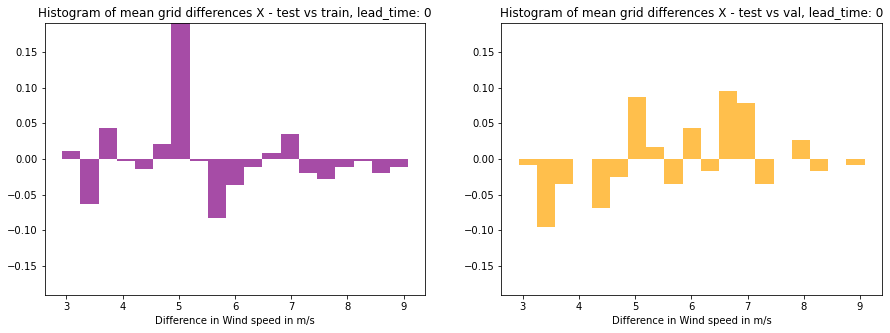

<IPython.core.display.Javascript object>

In [16]:
visualize_X_diff_hist()

#### 3.3 Histogramm y mean over grid for all forecasting days

In [17]:
def visualize_y_train_val_test_hist(var_num=5, lead_time=0):
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))

    train_data_mean_per_day = dat_y_train_lead_all_denorm[var_num][lead_time].mean(
        dim=["lat", "lon"]
    )
    val_data_mean_per_day = dat_y_val_lead_all_denorm[var_num][lead_time].mean(
        dim=["lat", "lon"]
    )
    test_data_mean_per_day = dat_y_test_lead_all_denorm[var_num][lead_time].mean(
        dim=["lat", "lon"]
    )

    # Calculate common scale for all histograms
    data_min = min(
        train_data_mean_per_day.min(),
        val_data_mean_per_day.min(),
        test_data_mean_per_day.min(),
    )
    data_max = max(
        train_data_mean_per_day.max(),
        val_data_mean_per_day.max(),
        test_data_mean_per_day.max(),
    )
    bins = np.linspace(data_min, data_max, 20)  # adjust number of bins if necessary

    hist0, _ = np.histogram(train_data_mean_per_day.values, bins=bins, density=True)
    hist1, _ = np.histogram(val_data_mean_per_day.values, bins=bins, density=True)
    hist2, _ = np.histogram(test_data_mean_per_day.values, bins=bins, density=True)

    max_y = max(np.max(hist0), np.max(hist1), np.max(hist2))

    ax[0].hist(
        train_data_mean_per_day.values,
        bins=bins,
        color="green",
        alpha=0.7,
        density=True,
    )
    ax[0].set_title(f"Histogram of daily y means - training, lead_time: {lead_time}")
    ax[0].set_xlabel("Wind speed in m/s")
    ax[0].set_ylim([0, max_y])

    ax[1].hist(
        val_data_mean_per_day.values, bins=bins, color="blue", alpha=0.7, density=True
    )
    ax[1].set_title(f"Histogram of daily y means - validation, lead_time: {lead_time}")
    ax[1].set_xlabel("Wind speed in m/s")
    ax[1].set_ylim([0, max_y])

    ax[2].hist(
        test_data_mean_per_day.values, bins=bins, color="red", alpha=0.7, density=True
    )
    ax[2].set_title(f"Histogram of daily y means - testing, lead_time: {lead_time}")
    ax[2].set_xlabel("Wind speed in m/s")
    ax[2].set_ylim([0, max_y])
    plt.show()

<IPython.core.display.Javascript object>

#### Figure 7

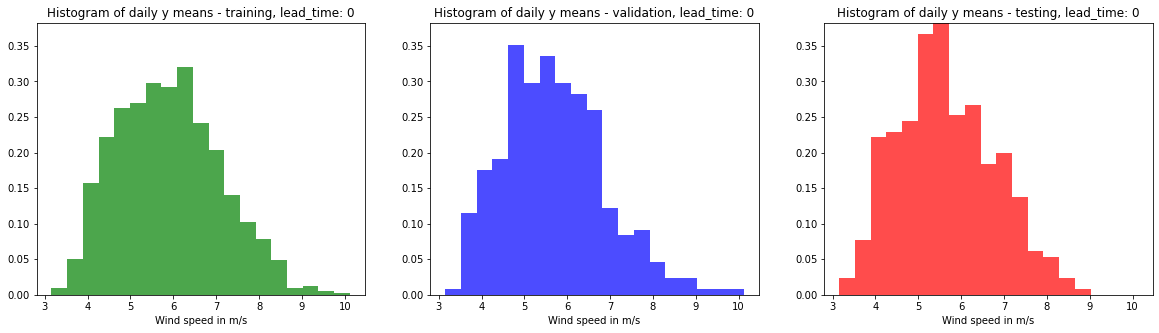

<IPython.core.display.Javascript object>

In [18]:
visualize_y_train_val_test_hist()

#### 3.4 Histogram y differences mean over grid

In [19]:
def visualize_y_diff_hist(var_num=5, lead_time=0):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    train_data_mean_per_day = dat_y_train_lead_all_denorm[var_num][lead_time].mean(
        dim=["lat", "lon"]
    )
    val_data_mean_per_day = dat_y_val_lead_all_denorm[var_num][lead_time].mean(
        dim=["lat", "lon"]
    )
    test_data_mean_per_day = dat_y_test_lead_all_denorm[var_num][lead_time].mean(
        dim=["lat", "lon"]
    )

    # Calculate common scale for all histograms
    data_min = min(
        train_data_mean_per_day.min(),
        val_data_mean_per_day.min(),
        test_data_mean_per_day.min(),
    )
    data_max = max(
        train_data_mean_per_day.max(),
        val_data_mean_per_day.max(),
        test_data_mean_per_day.max(),
    )
    bins = np.linspace(data_min, data_max, 20)  # adjust number of bins if necessary

    # Get histogram data
    train_hist, _ = np.histogram(
        train_data_mean_per_day.values, bins=bins, density=True
    )
    val_hist, _ = np.histogram(val_data_mean_per_day.values, bins=bins, density=True)
    test_hist, _ = np.histogram(test_data_mean_per_day.values, bins=bins, density=True)

    # Compute histogram differences
    diff_test_train = test_hist - train_hist
    diff_test_val = test_hist - val_hist

    # Compute the maximum absolute difference to set y-axis limits
    max_diff = max(abs(diff_test_train).max(), abs(diff_test_val).max())

    ax[0].bar(
        bins[:-1], diff_test_train, width=np.diff(bins), color="purple", alpha=0.7
    )
    ax[0].set_title(
        f"Histogram of mean grid differences y - test vs train, lead_time: {lead_time}"
    )
    ax[0].set_xlabel("Difference in Wind speed in m/s")
    ax[0].set_ylim([-max_diff, max_diff])

    ax[1].bar(bins[:-1], diff_test_val, width=np.diff(bins), color="orange", alpha=0.7)
    ax[1].set_title(
        f"Histogram of mean grid differences y - test vs val, lead_time: {lead_time}"
    )
    ax[1].set_xlabel("Difference in Wind speed in m/s")
    ax[1].set_ylim([-max_diff, max_diff])

    plt.show()

<IPython.core.display.Javascript object>

#### Figure 8

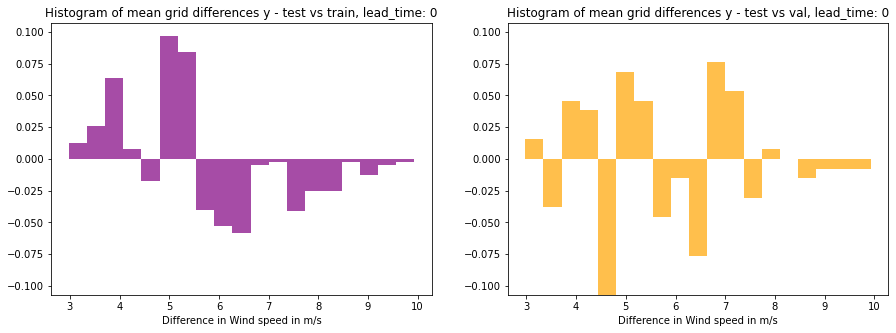

<IPython.core.display.Javascript object>

In [20]:
visualize_y_diff_hist(lead_time=0)